In [1]:
using Plots
using DiffEqFlux, OrdinaryDiffEq, Flux, Optim
include("/Users/piotrsokol/Documents/RNNODE.jl/src/rnn_ode.jl")
import DiffEqSensitivity: ischeckpointing, isconcretetype

In [2]:
ipt = sqrt(1/2)randn(Float32,3,100)
lpt = LinearInterpolationFixedGrid(ipt);
cpt = ConstantInterpolationFixedGrid(ipt);
spt = CubicSplineFixedGrid(ipt);

In [3]:
∂nn = ∂GRUCell(1,2)
tspan = [0.f0,100.f0]
tsteps = collect(tspan[1] : tspan[2])
node = RNNODE(∂nn, [0.f0,100.f0], saveat=tsteps);

In [4]:
# Testing forward solve, without input

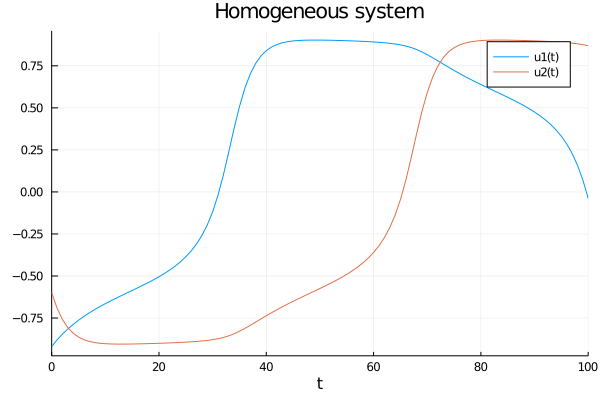

In [5]:
sol = node(node.u₀);
p1 = plot(sol, title="Homogeneous system")

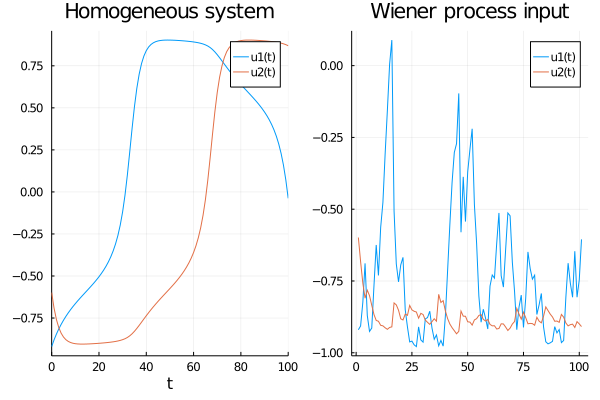

In [6]:
sol = node(cpt);
plot(p1, plot(permutedims(Array(sol)[:,1,:]), label = ["u1(t)" "u2(t)"], title = "Wiener process input") )

# Testing training w/t loss function $||h(t)||^2$

In [7]:
function predict_neuralode(p)
  Array(node(spt, p=p))
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, pred .- 0.0)
    return loss, pred
end
callback = function (p, l, pred; doplot = true)
  display(l)
  # plot current prediction against data
  if doplot
    display(plot( permutedims(pred[:,1,:]), label = ""))
  end
  return false
end

#52 (generic function with 1 method)

349.68407720636486

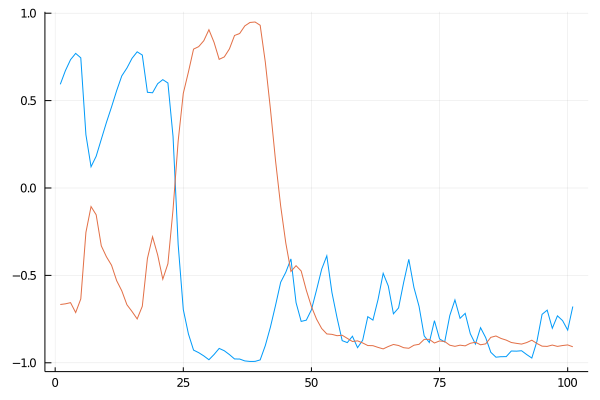

254.28297386745677

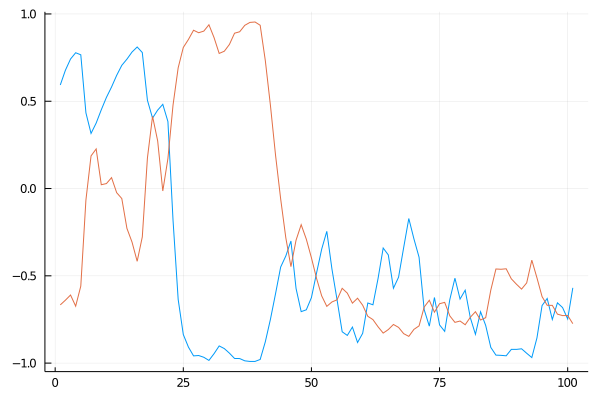

loss: 254:  40%|████████████████                        |  ETA: 0:00:00

254.96094138025697

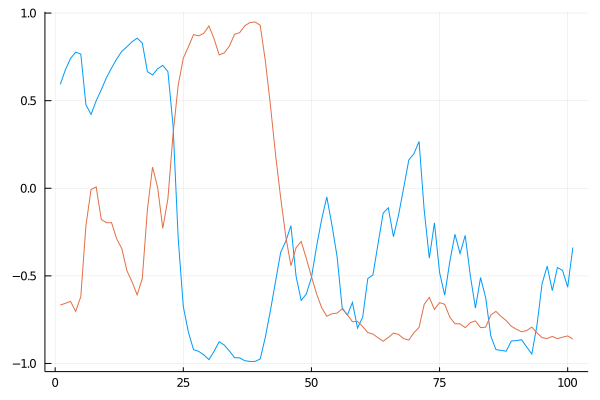

loss: 255:  60%|████████████████████████                |  ETA: 0:00:00

228.04794153313884

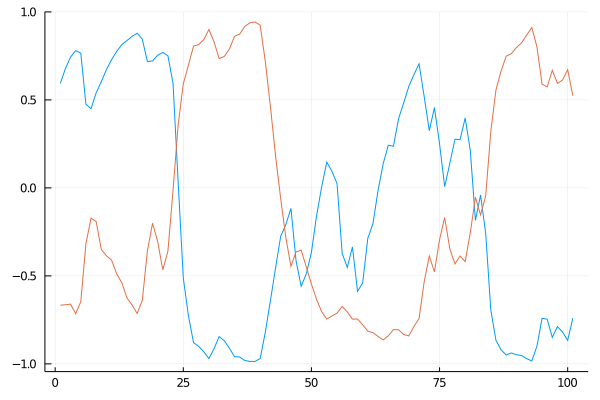

loss: 228:  80%|████████████████████████████████        |  ETA: 0:00:00

229.40947311509802

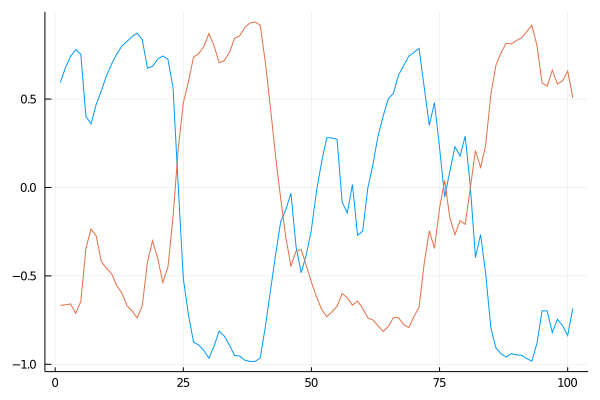

loss: 229: 100%|████████████████████████████████████████| Time: 0:00:00


228.04794153313884

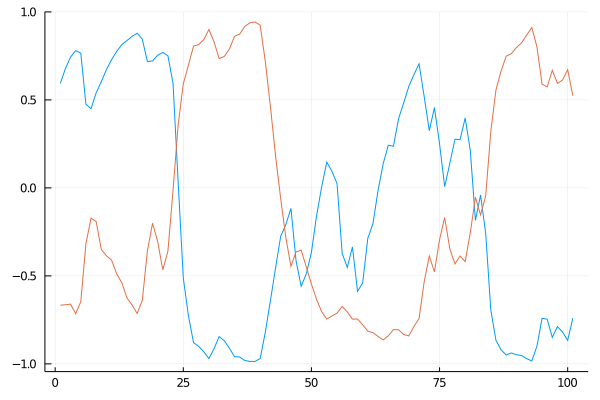

 * Status: success

 * Candidate solution
    Final objective value:     2.294095e+02

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    5
    f(x) calls:    5
    ∇f(x) calls:   5


In [13]:
#optim = LBFGS()
optim = ADAM(0.05)
result_neuralode = DiffEqFlux.sciml_train(loss_neuralode, node.p, optim, cb = callback, maxiters = 5)

# Testing adjoint callbacks

349.68407720636486

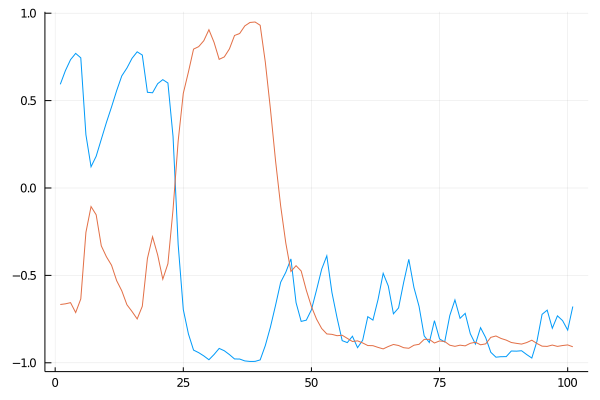

349.68407720636486

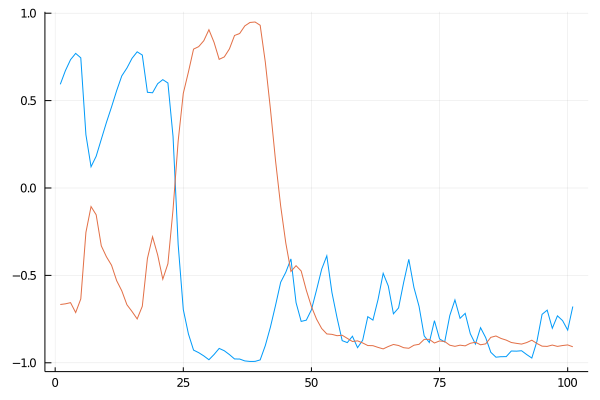

 * Status: success

 * Candidate solution
    Final objective value:     3.496841e+02

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    1
    f(x) calls:    1
    ∇f(x) calls:   1


In [9]:
saveat = collect(Float32, 0:5:100)
cb, saved_values = generate_adj_saving_callback(∂nn,saveat,3)
node = RNNODE(∂nn, [0.f0,100.f0], saveat=tsteps, callback_adj = cb);
function predict_neuralode(p)
  Array(node(spt, p=p))
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, pred .- 0.0)
    return loss, pred
end
callback = function (p, l, pred; doplot = true)
  display(l)
  # plot current prediction against data
  if doplot
    display(plot( permutedims(pred[:,1,:]), label = ""))
  end
  return false
end
result_neuralode = DiffEqFlux.sciml_train(loss_neuralode, node.p,
                                          ADAM(0.05), cb = callback,
                                          maxiters = 1)